# Timing Experiment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
import wiggum as wg
import sp_data_util as sp_dat
import time

We will draw samples from a number of clusters according to a Gaussian Mixture Model and add both continuous and categorical noise values.  

First we have to set up the number of clusters, samples and extra values. 


In [2]:
# set the data size
N = int(10**5)
# and 5 extra continuous attributes and 5 extra categorical attributes
num_clusters = 32
numExtra = 5

First, we generate cluseters that are roughly distributed with a positive trend that will help us ensure that SP occurs throughout the dataset

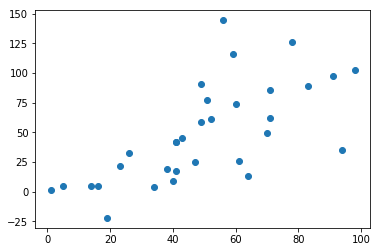

In [3]:
mu = np.asarray([[1,1],[5,5]])

variance = 1000

# generate rest of the mu
for i in range(num_clusters - 2):
    mu_x = np.random.randint(10, 99);
    mu_y = np.random.normal(mu_x, np.sqrt(variance))
    mu_new = np.asarray([mu_x,mu_y])
    mu = np.append(mu,[mu_new],axis=0)

plt.scatter(mu[:,0],mu[:,1])
plt.show()

Next we use a built in function to our package that takes a list of means and a covariance 

In [4]:
# covariance of each cluster
cov = [[.6,-1],[0,.6]]

# call mixed_regression_sp to generate the data set
latent_df = sp_dat.mixed_regression_sp_extra(N,mu,cov, numExtra)
    

/home/smb/anaconda2/envs/simpsonsparadox/lib/python3.6/site-packages/sp_data_util/SPData.py:134: RuntimeWarning: covariance is not positive-semidefinite.
  x = np.asarray([np.random.multivariate_normal(mu[z_i],cov) for z_i in z])


In [5]:
np.random.choice(range(5),20,)

array([3, 3, 3, 2, 2, 2, 4, 0, 1, 2, 1, 3, 0, 3, 4, 3, 4, 0, 3, 4])

In [6]:
latent_df['cluster'].head()

0    26
1    27
2     0
3     8
4     8
Name: cluster, dtype: int64

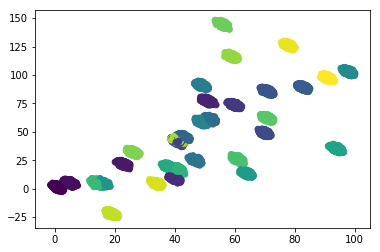

In [7]:
plt.scatter(latent_df['x1'], latent_df['x2'],
            c =  latent_df['cluster'], marker= 'o')
plt.show()

In [8]:
# check the size of the data
latent_df.shape

(100000, 13)

Since we store the data in a pandas dataframe, we can easily sample a subset of the rows and we can check how that works:

In [9]:
subset_df = latent_df.sample(frac=.1) 
print(len(subset_df))
subset_df.head()

10000


,x1,x2,cluster,con_0,con_1,con_2,con_3,con_4,cat_0,cat_1,cat_2,cat_3,cat_4
47787,40.285355,8.279074,4,42.821083,-5.945982,9.116584,47.626833,-7.233663,70,54,27,91,96
97210,34.170575,4.504379,29,-17.100323,-29.930051,-157.993357,26.581181,74.024540,72,64,23,13,60
42521,19.381192,-21.545576,28,-168.137523,-76.675448,146.536801,168.084883,178.468823,92,16,66,89,76
96452,51.975142,61.556268,11,35.396721,109.826010,98.528868,-37.957128,-179.428724,58,4,70,54,71
47115,42.532394,40.353842,6,91.515160,99.488643,-24.809279,-95.285213,145.379252,52,95,82,75,79


Now, we can do the Time experiment for the whole dataset and the sampled dataset.

In [10]:
# whole data set
data_portions = np.linspace(.1,1,10)

time_data = []

for cur_portion in data_portions:
    start_time = time.time()
    wg.detect_simpsons_paradox(latent_df.sample(frac=cur_portion))
    time_data.append([cur_portion, (time.time() - start_time)])

In [11]:
time_res = pd.DataFrame(data = time_data, columns =['portion of data','time'])
time_res # show the results

,portion of data,time
0,0.1,3.679361
1,0.2,3.910151
2,0.3,3.797533
3,0.4,4.676100
4,0.5,3.796321
5,0.6,4.221745
6,0.7,4.523880
7,0.8,4.056846
8,0.9,5.073282
9,1.0,5.017606


Computing it just once, is not the most indicative, so we can repeat the experiment and then compute statistics on that.  We repeat it 4 more times to get a total of 5

In [12]:
num_repeats = 4

for cur_portion in np.repeat(data_portions,num_repeats):
    start_time = time.time()
    wg.detect_simpsons_paradox(latent_df.sample(frac=cur_portion))
    time_data.append([cur_portion, (time.time() - start_time)])

In [13]:
time_res = pd.DataFrame(data = time_data, columns =['portion','time'])
len(time_res)

50

Now we have 50 rows in our result table and we can compute the statistics that we want.  We want to first, group the data by the portion of the data so that we can compute the mean and variance of all of the trials of each portion. 

In [14]:
time_repeats = time_res.groupby('portion')
time_repeats.describe()

time                                                              \
        count      mean       std       min       25%       50%       75%   
portion                                                                     
0.1       5.0  4.446497  0.826705  3.679361  3.812636  4.061862  5.313767   
0.2       5.0  4.256970  0.259700  3.910151  4.060727  4.379942  4.405277   
0.3       5.0  4.704718  0.929317  3.797533  4.171579  4.323587  5.094294   
0.4       5.0  3.936846  0.418850  3.666440  3.735602  3.749104  3.856985   
0.5       5.0  4.456102  0.752906  3.796321  4.026359  4.129114  4.646039   
0.6       5.0  4.540301  0.607244  4.137453  4.173215  4.221745  4.592580   
0.7       5.0  4.545214  0.508978  4.006332  4.097922  4.523880  4.911530   
0.8       5.0  4.289220  0.594578  3.791577  3.839077  4.056846  4.552631   
0.9       5.0  4.318349  0.453169  3.968818  4.045736  4.099937  4.403975   
1.0       5.0  4.496278  0.573671  3.903625  3.998321  4.404508  5.017606   

                   
              max  
portion            
0.1      5.364857  
0.2      4.528751  
0.3      6.136595  
0.4      4.676100  
0.5      5.682674  
0.6      5.576510  
0.7      5.186406  
0.8      5.205971  
0.9      5.073282  
1.0      5.157329

We can plot the means to see if there's a clear trend

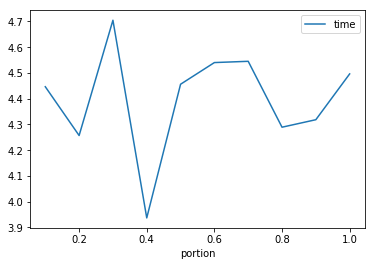

In [15]:
time_repeats.mean().plot()